# HEP Benchmark Queries Q1 to Q5

This follows the [IRIS-HEP benchmark](https://github.com/iris-hep/adl-benchmarks-index)
and the article [Evaluating Query Languages and Systems for High-Energy Physics Data](https://arxiv.org/abs/2104.12615)
and provides implementations of the benchmark tasks using Apache Spark.

The workload and data:
  - Benchmark jobs are implemented follwing [IRIS-HEP benchmark](https://github.com/iris-hep/adl-benchmarks-index)
  - The input data is a series of events from CMS opendata
  - The job output is typically a histogram 
  - See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

Author and contact: Luca.Canali@cern.ch  
February, 2022


In [ ]:
# Download the data if not yet available locally

# Download the reduced data set (2 GB)
! wget -r -np -R "index.html*" -e robots=off https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012B_SingleMu_sample.orc/

# This downloads the full dataset (16 GB)
# ! wget -r -np -R "index.html*" -e robots=off https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012B_SingleMu.orc/

In [ ]:
# Start the Spark Session
# This uses local mode for simplicity
# The use of findspark is optional

import findspark
findspark.init("/home/luca/Spark/spark-3.2.1-bin-hadoop3.2")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("HEP benchmark")
         .master("local[4]")
         .config("spark.driver.memory", "4g")
         .config("spark.sql.orc.enableNestedColumnVectorizedReader", "true")
         .getOrCreate()
        )


In [3]:
# Read data for the benchmark tasks
# download data as detailed at https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

path = "sparkdltrigger.web.cern.ch/sparkdltrigger/"
input_data = "Run2012B_SingleMu_sample.orc"

# use this if you downloaded the full dataset
# input_data = "Run2012B_SingleMu.orc"

df_events = spark.read.orc(path + input_data)

df_events.printSchema()

print(f"Number of events: {df_events.count()}")

root
 |-- run: integer (nullable = true)
 |-- luminosityBlock: long (nullable = true)
 |-- event: long (nullable = true)
 |-- HLT_IsoMu24_eta2p1: boolean (nullable = true)
 |-- HLT_IsoMu24: boolean (nullable = true)
 |-- HLT_IsoMu17_eta2p1_LooseIsoPFTau20: boolean (nullable = true)
 |-- PV_npvs: integer (nullable = true)
 |-- PV_x: float (nullable = true)
 |-- PV_y: float (nullable = true)
 |-- PV_z: float (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Muon_pfRelIso03_all: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- 

Number of events: 6609108


# Benchmark task: Q1
Plot the $𝐸^{𝑚𝑖𝑠𝑠}_T$ (missing transverse energy) of all events.

In [4]:
# Compute the histogram for MET_pt
# The Spark function "width_bucket" is used to generate the histogram bucket number
# a groupBy operation with count is used to fill the histogram
# The result is a histogram with bins value and counts foreach bin (N_events)

min_val = 0
max_val = 100
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_events
        .selectExpr(f"width_bucket(MET_pt, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [5]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 275 ms, sys: 34 ms, total: 309 ms
Wall time: 2.2 s


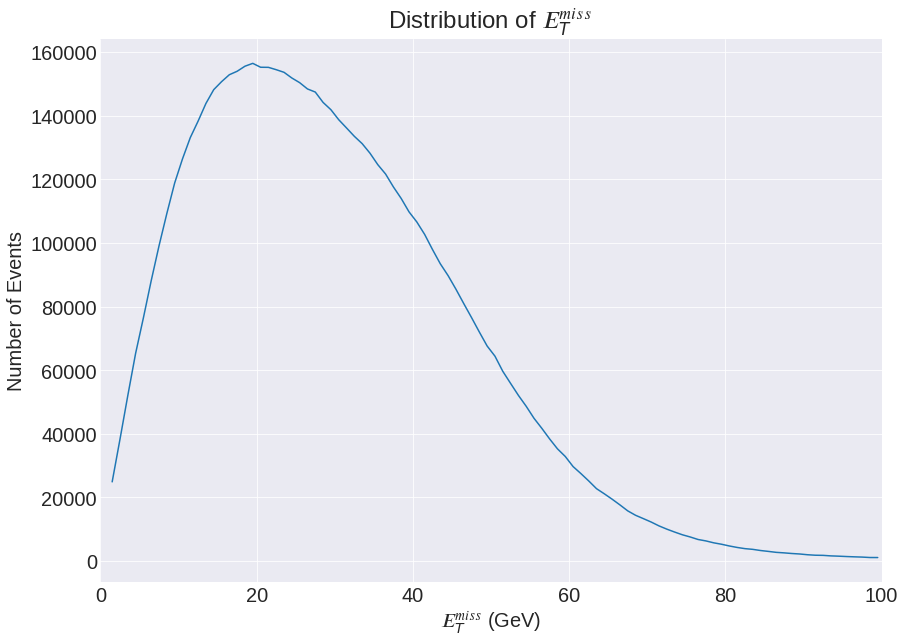

In [6]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlim(min_val, max_val)
ax.set_xlabel('$𝐸^{𝑚𝑖𝑠𝑠}_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of $𝐸^{𝑚𝑖𝑠𝑠}_T$ ")

plt.show()

# Benchmark task: Q2
 Plot the $𝑝_𝑇$ (transverse momentum) of all jets in all events

In [7]:
# Jet_pt contains arrays of jet measurements

df_events.select("Jet_pt").show(5,False)

+-------------------------------------------------------------------------------------+
|Jet_pt                                                                               |
+-------------------------------------------------------------------------------------+
|[28.03698, 20.425129, 18.646175, 17.995762, 17.04349, 16.52969, 16.171753, 15.045278]|
|[]                                                                                   |
|[]                                                                                   |
|[44.719715]                                                                          |
|[38.958744, 30.210083, 15.007741]                                                    |
+-------------------------------------------------------------------------------------+
only showing top 5 rows



In [8]:
# Use the explode function to extract array data into DataFrame rows
df_events_jet_pt = df_events.selectExpr("explode(Jet_pt) as Jet_pt")

df_events_jet_pt.printSchema()
df_events_jet_pt.show(10, False)

root
 |-- Jet_pt: float (nullable = true)

+---------+
|Jet_pt   |
+---------+
|28.03698 |
|20.425129|
|18.646175|
|17.995762|
|17.04349 |
|16.52969 |
|16.171753|
|15.045278|
|44.719715|
|38.958744|
+---------+
only showing top 10 rows



In [9]:
# Compute the histogram for Jet_pt
# The Spark function "width_bucket" is used to generate the histogram bucket number
# a groupBy operation with count is used to fill the histogram
# The result is a histogram with bins value and counts foreach bin (N_events)

min_val = 15
max_val = 60
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_events_jet_pt
        .selectExpr(f"width_bucket(Jet_pt, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [10]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()

CPU times: user 13.2 ms, sys: 2.92 ms, total: 16.2 ms
Wall time: 1.45 s


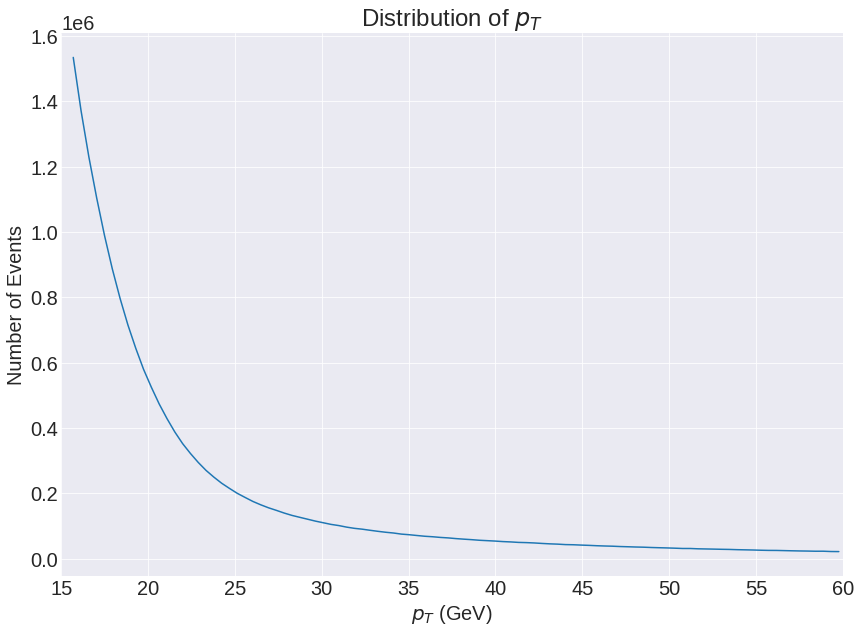

In [11]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlim(min_val, max_val)
ax.set_xlabel('$p_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of $p_T$ ")

plt.show()

# Benchmark task: Q3
Plot the $𝑝_𝑇$ of jets with |𝜂| < 1 (𝜂 is the jet pseudorapidity).

In [12]:
# Take Jet arrays for pt and eta and transform them to rows with explode()

df1 = df_events.selectExpr("explode(arrays_zip(Jet_pt, Jet_eta)) as Jet")
df1.printSchema()
df1.show(10, False)

root
 |-- Jet: struct (nullable = false)
 |    |-- Jet_pt: float (nullable = true)
 |    |-- Jet_eta: float (nullable = true)

+-----------------------+
|Jet                    |
+-----------------------+
|{28.03698, -2.573142}  |
|{20.425129, -0.6191127}|
|{18.646175, 2.5256636} |
|{17.995762, -3.8685246}|
|{17.04349, -3.4595842} |
|{16.52969, -3.540888}  |
|{16.171753, 2.5842555} |
|{15.045278, 2.9945173} |
|{44.719715, 0.4003274} |
|{38.958744, 0.50525355}|
+-----------------------+
only showing top 10 rows



In [13]:
# Apply a filter on Jet_eta

q3 = df1.select("Jet.Jet_pt").filter("abs(Jet.Jet_eta) < 1")
q3.show(10,False)

+---------+
|Jet_pt   |
+---------+
|20.425129|
|44.719715|
|38.958744|
|26.291018|
|30.949333|
|18.85824 |
|17.259293|
|16.906128|
|18.320488|
|17.826782|
+---------+
only showing top 10 rows



In [14]:
# Compute the histogram for Jet_pt
# The Spark function "width_bucket" is used to generate the histogram bucket number
# a groupBy operation with count is used to fill the histogram
# The result is a histogram with bins value and counts foreach bin (N_events)


min_val = 15
max_val = 60
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    q3
        .selectExpr(f"width_bucket(Jet_pt, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [15]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()

CPU times: user 11.9 ms, sys: 2.53 ms, total: 14.5 ms
Wall time: 1.72 s


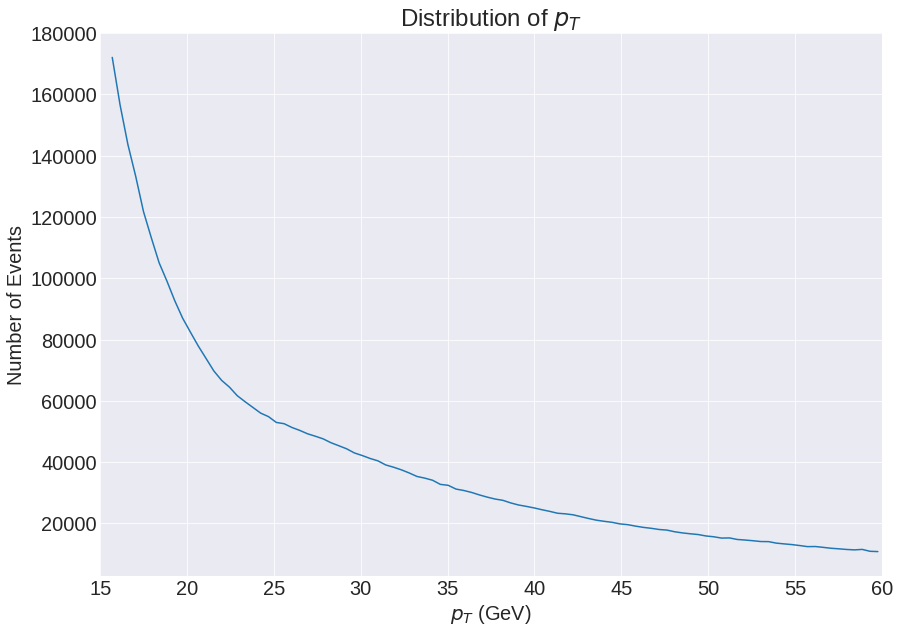

In [16]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlim(min_val, max_val)
ax.set_xlabel('$p_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of $p_T$ ")

plt.show()

# Benchmark task: Q4
Plot the $𝐸^{𝑚𝑖𝑠𝑠}_𝑇$ of the events that have at least two jets with
$𝑝_𝑇$ > 40 GeV (gigaelectronvolt).

In [17]:
# This will use MET adn Jet_pt
df_events.select("MET_pt","Jet_pt").show(10,False)

+---------+-------------------------------------------------------------------------------------+
|MET_pt   |Jet_pt                                                                               |
+---------+-------------------------------------------------------------------------------------+
|35.60389 |[28.03698, 20.425129, 18.646175, 17.995762, 17.04349, 16.52969, 16.171753, 15.045278]|
|40.162342|[]                                                                                   |
|17.302282|[]                                                                                   |
|20.676792|[44.719715]                                                                          |
|28.61501 |[38.958744, 30.210083, 15.007741]                                                    |
|66.72799 |[16.342604, 15.149042]                                                               |
|23.462498|[15.248867]                                                                          |
|20.586023|[155.6700

In [18]:
# The filter ispushed inside arrays of Jet_pt
# This use Spark's higher order functions for array processing

q4 = df_events.select("MET_pt").where("cardinality(filter(Jet_pt, x -> x > 40)) > 1")
q4.show(5,False)

+---------+
|MET_pt   |
+---------+
|20.586023|
|18.8028  |
|9.113723 |
|28.647303|
|16.368444|
+---------+
only showing top 5 rows



In [19]:
# compute the histogram for MET_pt

min_val = 0
max_val = 100
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    q4
        .selectExpr(f"width_bucket(MET_pt, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [20]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()

CPU times: user 13.4 ms, sys: 1.06 ms, total: 14.5 ms
Wall time: 1.49 s


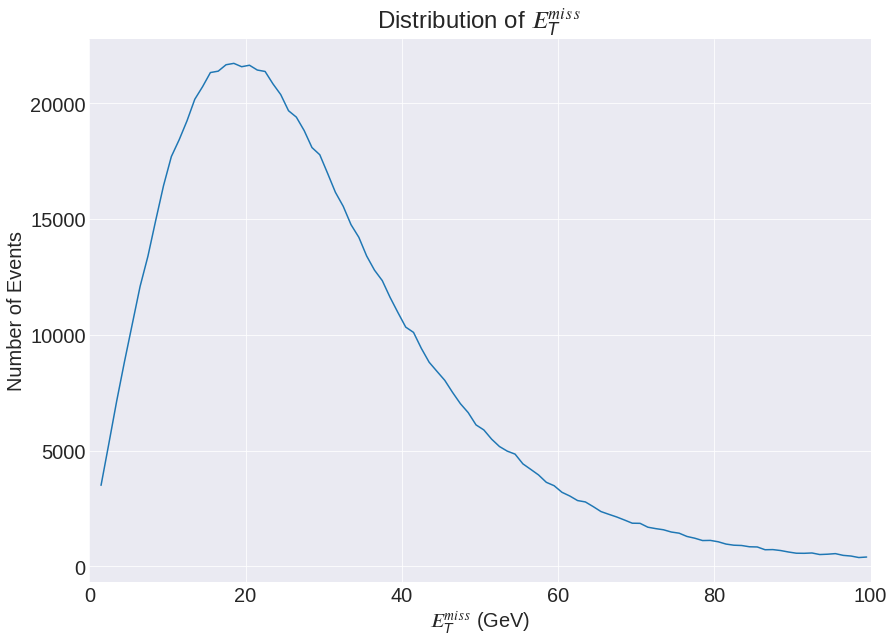

In [21]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlim(min_val, max_val)
ax.set_xlabel('$𝐸^{𝑚𝑖𝑠𝑠}_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of $𝐸^{𝑚𝑖𝑠𝑠}_T$ ")

plt.show()

# Benchmark task: Q5
Plot the $𝐸^{𝑚𝑖𝑠𝑠}_T$ of events that have an opposite-charge muon
pair with an invariant mass between 60 GeV and 120 GeV.

In [22]:
# filter the events 
# select only events with 2 muons
# the 2 muons must have opposite charge

df_muons = df_events.filter("nMuon == 2").filter("Muon_charge[0] != Muon_charge[1]")

In [23]:
# Formula for dimuon mass in pt, eta, phi, m coordinates
# see also http://edu.itp.phys.ethz.ch/hs10/ppp1/2010_11_02.pdf
# and https://en.wikipedia.org/wiki/Invariant_mass

df_with_dimuonmass = df_muons.selectExpr("MET_pt",""" 
     sqrt(2 * Muon_pt[0] * Muon_pt[1] * 
           ( cosh(Muon_eta[0] - Muon_eta[1]) - cos(Muon_phi[0] - Muon_phi[1]) )
         ) as Dimuon_mass
         """)

In [24]:
# apply a filter on the dimuon mass

Q5 = df_with_dimuonmass.filter("Dimuon_mass between 60 and 120")

In [25]:
# compute the histogram for MET_pt

min_val = 0
max_val = 100
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    Q5
        .selectExpr(f"width_bucket(MET_pt, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [26]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()

CPU times: user 12.9 ms, sys: 3.6 ms, total: 16.5 ms
Wall time: 1.82 s


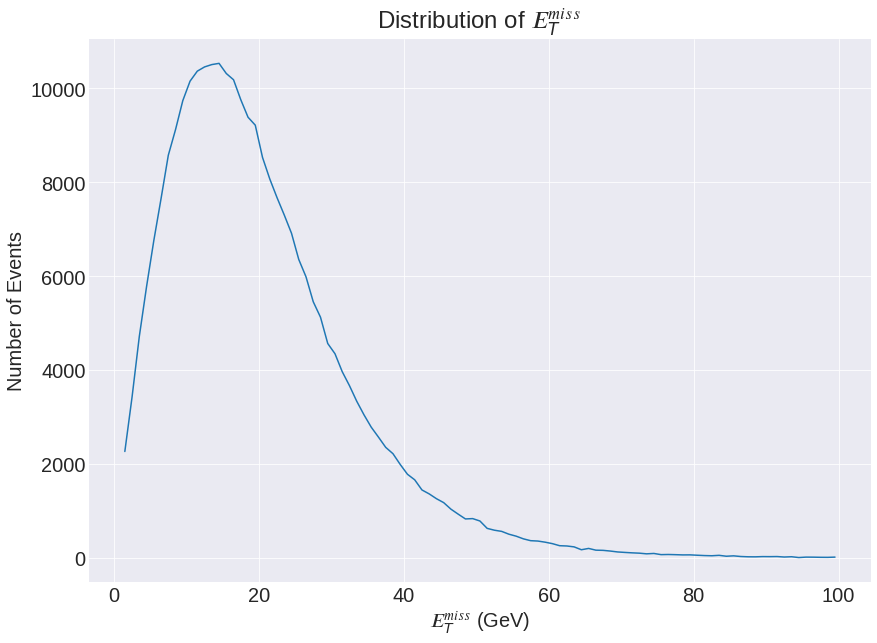

In [27]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('$𝐸^{𝑚𝑖𝑠𝑠}_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of $𝐸^{𝑚𝑖𝑠𝑠}_T$ ")

plt.show()

In [28]:
spark.stop()